In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import chi2_contingency

from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV,RandomizedSearchCV,StratifiedKFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier ,GradientBoostingClassifier,VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,recall_score,ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [266]:
data = pd.read_csv("C:\\Users\\Rohit Mhatre\\Downloads\\LendinClub_reduced.csv")
print(data.shape)
df = data.copy()
df.head()

(90000, 15)


,loan_amnt,int_rate,installment,grade,emp_length,annual_inc,dti,fico_range_low,revol_util,total_rec_prncp,purpose,loan_status,verification_status,last_pymnt_amnt,total_rec_int
0,5000.0,16.02,175.84,C,10+ years,65000.0,22.56,660.0,42.0,5000.00,debt_consolidation,Fully Paid,Not Verified,2776.11,498.09
1,8000.0,10.99,261.88,B,10+ years,60000.0,31.02,675.0,42.1,571.04,credit_card,Charged Off,Source Verified,261.88,214.60
2,20000.0,6.03,608.72,A,10+ years,70000.0,16.87,730.0,45.0,20000.00,debt_consolidation,Fully Paid,Source Verified,12751.89,1273.97
3,3000.0,22.15,114.81,E,5 years,60000.0,23.79,675.0,78.0,3000.00,other,Fully Paid,Not Verified,114.52,1132.87
4,15000.0,10.99,326.07,B,< 1 year,44800.0,11.20,685.0,53.3,15000.00,debt_consolidation,Fully Paid,Not Verified,12790.43,1694.11


In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            90000 non-null  float64
 1   int_rate             90000 non-null  float64
 2   installment          90000 non-null  float64
 3   grade                90000 non-null  object 
 4   emp_length           84801 non-null  object 
 5   annual_inc           90000 non-null  float64
 6   dti                  89984 non-null  float64
 7   fico_range_low       90000 non-null  float64
 8   revol_util           89941 non-null  float64
 9   total_rec_prncp      90000 non-null  float64
 10  purpose              90000 non-null  object 
 11  loan_status          90000 non-null  object 
 12  verification_status  90000 non-null  object 
 13  last_pymnt_amnt      90000 non-null  float64
 14  total_rec_int        90000 non-null  float64
dtypes: float64(10), object(5)
memory usa

In [268]:
num_cols = df.select_dtypes(include=['float64'])
cat_cols = df.select_dtypes(include=['object'])

In [269]:
num_cols.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,fico_range_low,revol_util,total_rec_prncp,last_pymnt_amnt,total_rec_int
count,90000.00000,90000.000000,90000.000000,9.000000e+04,89984.000000,90000.000000,89941.000000,90000.000000,90000.000000,90000.000000
mean,14385.01000,13.279442,436.873747,7.592054e+04,18.303077,696.099889,51.964250,12136.158538,5406.871775,2397.913924
std,8716.42602,4.781591,261.086459,5.433543e+04,11.481359,31.842579,24.471108,8853.015992,7113.033996,2606.490534
min,1000.00000,5.310000,23.610000,0.000000e+00,0.000000,630.000000,0.000000,0.000000,0.000000,0.000000
25%,7900.00000,9.750000,247.430000,4.500825e+04,11.810000,670.000000,33.700000,5000.000000,400.240000,763.547500
50%,12000.00000,12.740000,373.730000,6.500000e+04,17.650000,690.000000,52.400000,10000.000000,2016.445000,1567.730000
75%,20000.00000,16.020000,580.290000,9.000000e+04,24.070000,710.000000,70.700000,17100.000000,8163.672500,3038.010000
max,40000.00000,30.990000,1719.830000,4.200000e+06,999.000000,845.000000,182.800000,40000.000000,41453.070000,27862.510000


In [270]:
for col in cat_cols:
    print(col,":  ",df[col].unique())
    print('\n')

grade :   ['C' 'B' 'A' 'E' 'D' 'F' 'G']


emp_length :   ['10+ years' '5 years' '< 1 year' '1 year' '4 years' '8 years' '3 years'
 '2 years' '7 years' '6 years' '9 years' nan]


purpose :   ['debt_consolidation' 'credit_card' 'other' 'home_improvement'
 'major_purchase' 'small_business' 'vacation' 'medical' 'moving' 'wedding'
 'house' 'renewable_energy' 'car' 'educational']


loan_status :   ['Fully Paid' 'Charged Off' 'Default']


verification_status :   ['Not Verified' 'Source Verified' 'Verified']




Below we try to see the loan amount for different grade

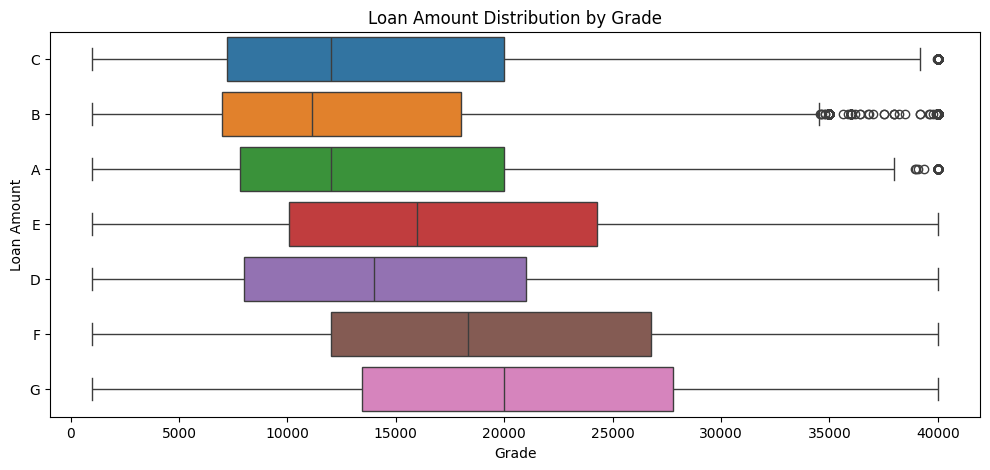

In [271]:
plt.figure(figsize=(12, 5))
sb.boxplot(data=df, x ='loan_amnt', y='grade', hue='grade')
plt.title("Loan Amount Distribution by Grade")
plt.xlabel("Grade")
plt.ylabel("Loan Amount")
plt.show();

1. A,B,C has the lower loan amount , may be they have good credit score and not needed higher loans .
2. E,D,F,G has the higher loan amount these grade may be riskier.
3. Some Grade like A,B,C has outlier has taken higher loan (loan_amont > $35000)

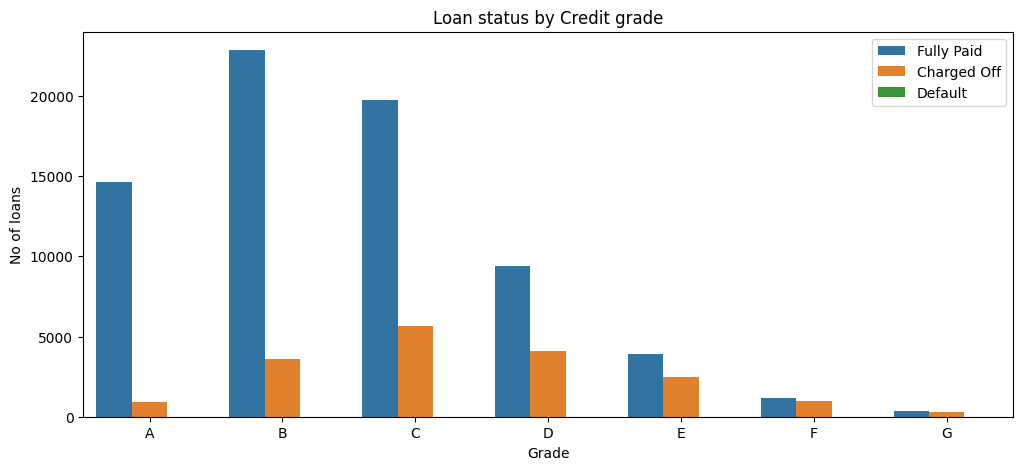

In [272]:
plt.figure(figsize=(12,5))
sb.countplot(data = df ,x = 'grade',hue = 'loan_status',order = ['A','B','C','D','D','E','F','G'])
plt.title('Loan status by Credit grade')
plt.xlabel('Grade')
plt.ylabel('No of loans')
plt.legend()
plt.show();

1. Grade A,B,C have almost fully paid the loans look like less riskier.
2. Grade B and C has the highest Charged off due to the due to the outlier we saw before in boxplot.

In [273]:
pd.crosstab(df['grade'], [df['loan_status'], df['verification_status']])

loan_status          Charged Off                                  Default  \
verification_status Not Verified Source Verified Verified Source Verified   
grade                                                                       
A                            347             347      198               0   
B                           1136            1440     1005               0   
C                           1275            2379     2013               0   
D                            700            1703     1663               1   
E                            289            1025     1134               0   
F                             77             370      555               0   
G                             18             108      184               0   

loan_status                    Fully Paid                           
verification_status Verified Not Verified Source Verified Verified  
grade                                                               
A                          0         6836            5050     2719  
B                          0         8128            8951     5775  
C                          1         5274            7901     6591  
D                          0         2108            3590     3698  
E                          0          557            1566     1788  
F                          1          106             423      629  
G                          0           22             100      219

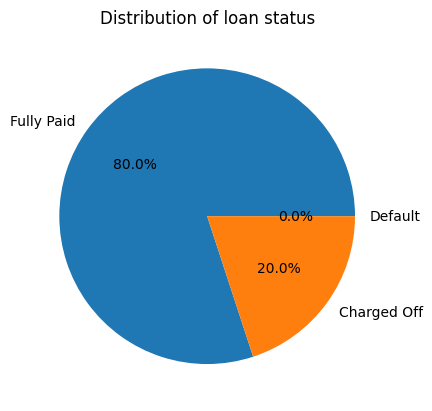

In [274]:
loan_status_counts = df['loan_status'].value_counts()
plt.pie(x = loan_status_counts,labels = loan_status_counts.index,autopct = '%1.1f%%')
plt.title("Distribution of loan status")
plt.show()

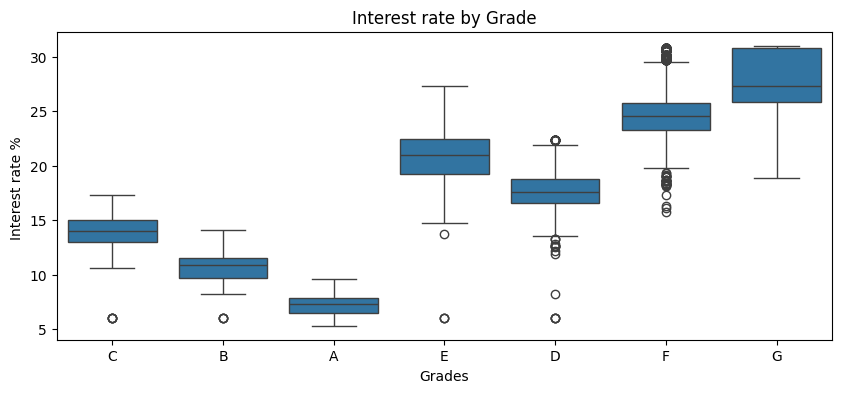

In [275]:
plt.figure(figsize=(10,4))
sb.boxplot(data = df,x = 'grade', y = 'int_rate')
plt.title('Interest rate by Grade')
plt.xlabel('Grades')
plt.ylabel('Interest rate % ')
plt.show();

We can clearly see that Grades with higher credit points have lower interest rate and lower credit points tend to have higher credit points

In [276]:
loan_amnt_grp = df.groupby('grade')['loan_amnt'].sum()
recovered_amnt_grp = df.groupby('grade')['total_rec_prncp'].sum()

summary_df = pd.DataFrame({'Total Loan Amount': loan_amnt_grp, 'Total Principal Recovered': recovered_amnt_grp})
summary_df['Revovery rate %'] = (summary_df['Total Loan Amount'] / summary_df['Total Principal Recovered']) * 100
summary_df

,Total Loan Amount,Total Principal Recovered,Revovery rate %
grade,,,
A,213800950.0,2.064768e+08,103.547217
B,348700950.0,3.180997e+08,109.620021
C,358320825.0,2.989889e+08,119.844192
D,207270300.0,1.580343e+08,131.155299
E,111429950.0,7.709502e+07,144.535861
F,41759925.0,2.556927e+07,163.320778
G,13368000.0,7.990369e+06,167.301404


In [277]:
df.head(2)

,loan_amnt,int_rate,installment,grade,emp_length,annual_inc,dti,fico_range_low,revol_util,total_rec_prncp,purpose,loan_status,verification_status,last_pymnt_amnt,total_rec_int
0,5000.0,16.02,175.84,C,10+ years,65000.0,22.56,660.0,42.0,5000.00,debt_consolidation,Fully Paid,Not Verified,2776.11,498.09
1,8000.0,10.99,261.88,B,10+ years,60000.0,31.02,675.0,42.1,571.04,credit_card,Charged Off,Source Verified,261.88,214.60


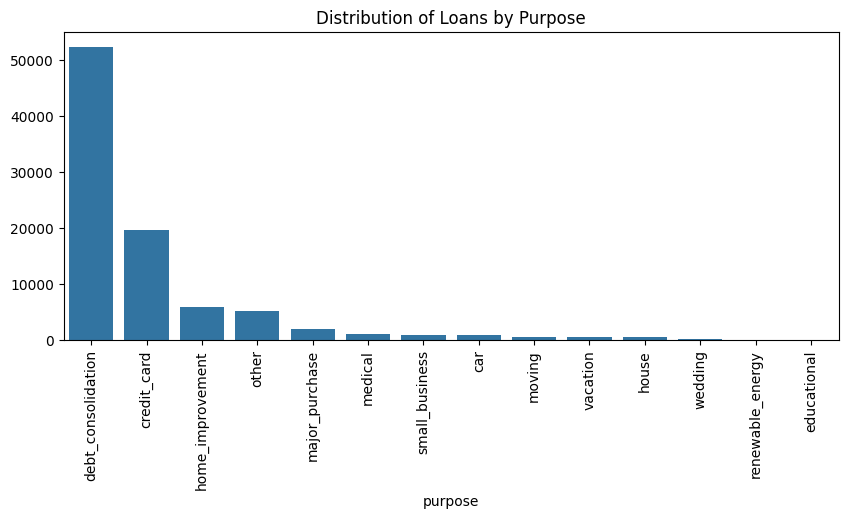

In [278]:
loan_purpose_cnt = df['purpose'].value_counts()
plt.figure(figsize=(10,4))
sb.barplot(x = loan_purpose_cnt.index,y = loan_purpose_cnt.values)
plt.title("Distribution of Loans by Purpose")
plt.xticks(rotation=90)
plt.show();

In [279]:
df.groupby('loan_status')[['loan_amnt','total_rec_prncp']].agg(['sum','mean','count'])

loan_amnt                      total_rec_prncp                \
                      sum          mean  count             sum          mean   
loan_status                                                                    
Charged Off  2.806938e+08  15623.612657  17966    7.906436e+07   4400.776881   
Default      3.895000e+04  12983.333333      3    1.066205e+04   3554.016667   
Fully Paid   1.013918e+09  14076.135622  72031    1.013179e+09  14065.877871   

                    
             count  
loan_status         
Charged Off  17966  
Default          3  
Fully Paid   72031

In [280]:
df.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,17965.0,20.205534,12.430350,0.0,13.620,19.76,26.330,999.00
Default,3.0,13.516667,12.602430,1.7,6.885,12.07,19.425,26.78
Fully Paid,72016.0,17.828692,11.181912,0.0,11.420,17.14,23.460,999.00


<Axes: >

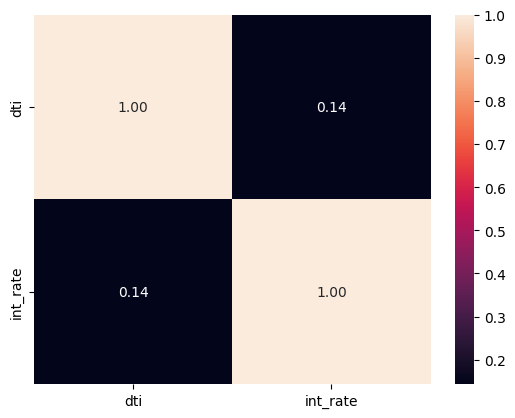

In [281]:
dti_corr = df[['dti','int_rate']].corr()
sb.heatmap(dti_corr,annot=True,fmt = '.2f')

In [282]:
df.groupby('emp_length')['loan_amnt'].agg(['mean','sum','count'])

,mean,sum,count
emp_length,,,
1 year,13356.127576,78413825.0,5871
10+ years,15595.098056,462020375.0,29626
2 years,13714.134827,111989625.0,8166
3 years,13843.352541,99699825.0,7202
4 years,13900.321928,75562150.0,5436
5 years,14155.845096,78225200.0,5526
6 years,14126.486550,59868050.0,4238
7 years,14541.825025,58923475.0,4052
8 years,14665.238037,59452875.0,4054


In [283]:
df.groupby('purpose')[['loan_amnt','total_rec_prncp','int_rate']].mean().sort_values(by='loan_amnt',ascending=False)

,loan_amnt,total_rec_prncp,int_rate
purpose,,,
small_business,16084.068136,12222.912846,16.019719
house,15429.830677,12848.018924,15.702052
debt_consolidation,15211.571358,12697.309615,13.657075
credit_card,14760.290446,12965.113373,11.814865
home_improvement,14094.721183,11978.386447,12.848416
major_purchase,11958.143364,9841.777204,12.782047
wedding,10595.754717,9523.020755,14.462516
other,9553.165753,7854.355678,14.590595
medical,8836.635833,7115.702648,14.241821


In [284]:
df.select_dtypes(include=['O']).head()

,grade,emp_length,purpose,loan_status,verification_status
0,C,10+ years,debt_consolidation,Fully Paid,Not Verified
1,B,10+ years,credit_card,Charged Off,Source Verified
2,A,10+ years,debt_consolidation,Fully Paid,Source Verified
3,E,5 years,other,Fully Paid,Not Verified
4,B,< 1 year,debt_consolidation,Fully Paid,Not Verified


In [285]:
df['loan_status'] = df['loan_status'].map({'Fully Paid':0,'Charged Off':1,'Default':1}).astype(int)

Statistics - Analysis of variance to test whether the purpose and loan_status are dependent or not ?

- Null Hypothesis (H0) : There is no significant effect or relationship .
- Alternate Hypothesis (H1) : There is significant effect (At least one loan purpose category has relation) .


In [292]:
contingency = pd.crosstab(data['loan_status'],data['purpose'])
chi2, p_val, dof, expected = chi2_contingency(contingency)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies Table:\n {expected}")

Chi-Square Statistic: 337.4469254090298
P-value: 6.337707077209207e-56
Degrees of Freedom: 26
Expected Frequencies Table:
 [[1.89441489e+02 3.91758611e+03 1.04444343e+04 3.59320000e+00
  1.17417791e+03 1.00210356e+02 3.94054267e+02 2.05012022e+02
  1.22168800e+02 1.05620118e+03 1.21769556e+01 1.99222978e+02
  1.15980511e+02 3.17399333e+01]
 [3.16333333e-02 6.54166667e-01 1.74403333e+00 6.00000000e-04
  1.96066667e-01 1.67333333e-02 6.58000000e-02 3.42333333e-02
  2.04000000e-02 1.76366667e-01 2.03333333e-03 3.32666667e-02
  1.93666667e-02 5.30000000e-03]
 [7.59526878e+02 1.57067597e+04 4.18748217e+04 1.44062000e+01
  4.70762602e+03 4.01772911e+02 1.57987993e+03 8.21953744e+02
  4.89810800e+02 4.23462246e+03 4.88210111e+01 7.98743756e+02
  4.65000122e+02 1.27254767e+02]]


In [293]:
if p_val < chi2:
    print("Reject Null Hypothesis there is significant relationship between any of the loan purpose")
else:
    print("Fail to reject the null Hypothesis loan purpose does not affect the loan status")

Reject Null Hypothesis there is significant relationship between any of the loan purpose


In [25]:
grade_ord = [['A','B','C','D','E','F','G']]
ord_enc = OrdinalEncoder(categories = grade_ord)
df['grade'] = ord_enc.fit_transform(df[['grade']])

In [26]:
verification_status   =   {'Not Verified':2, 'Source Verified':1, 'Verified':0}
df['verification_status'] = df['verification_status'].map(verification_status).astype(int)

In [27]:
df.isnull().sum()

loan_amnt                 0
int_rate                  0
installment               0
grade                     0
emp_length             5199
annual_inc                0
dti                      16
fico_range_low            0
revol_util               59
total_rec_prncp           0
purpose                   0
loan_status               0
verification_status       0
last_pymnt_amnt           0
total_rec_int             0
dtype: int64

In [28]:
df.dropna(subset = ['dti'],axis=0,inplace=True)

In [29]:
df['emp_length'].unique()

array(['10+ years', '5 years', '< 1 year', '1 year', '4 years', '8 years',
       '3 years', '2 years', '7 years', '6 years', '9 years', nan],
      dtype=object)

In [30]:
df['emp_length'] = df['emp_length'].replace('< 1 year','0 years')
df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)

Outliers detection

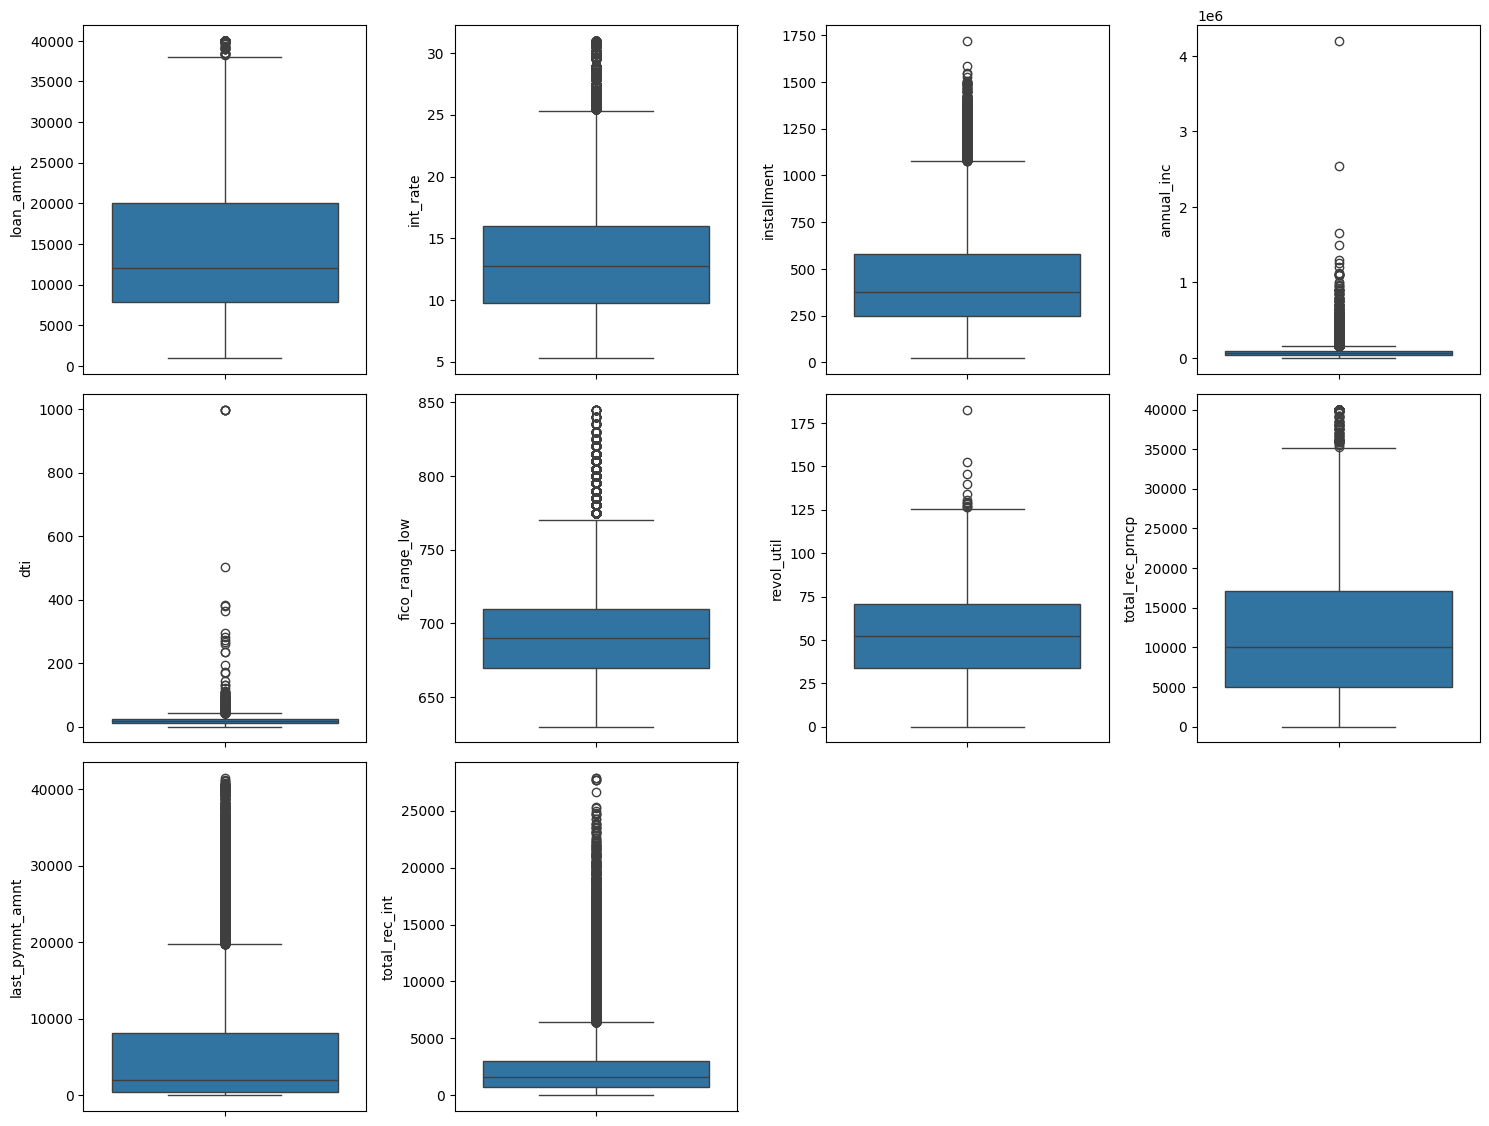

In [254]:
plt.figure(figsize=(15,15))
for i , col in enumerate(num_cols,1):
    plt.subplot(4,4,i)
    sb.boxplot(df[col])
plt.tight_layout()
plt.show();

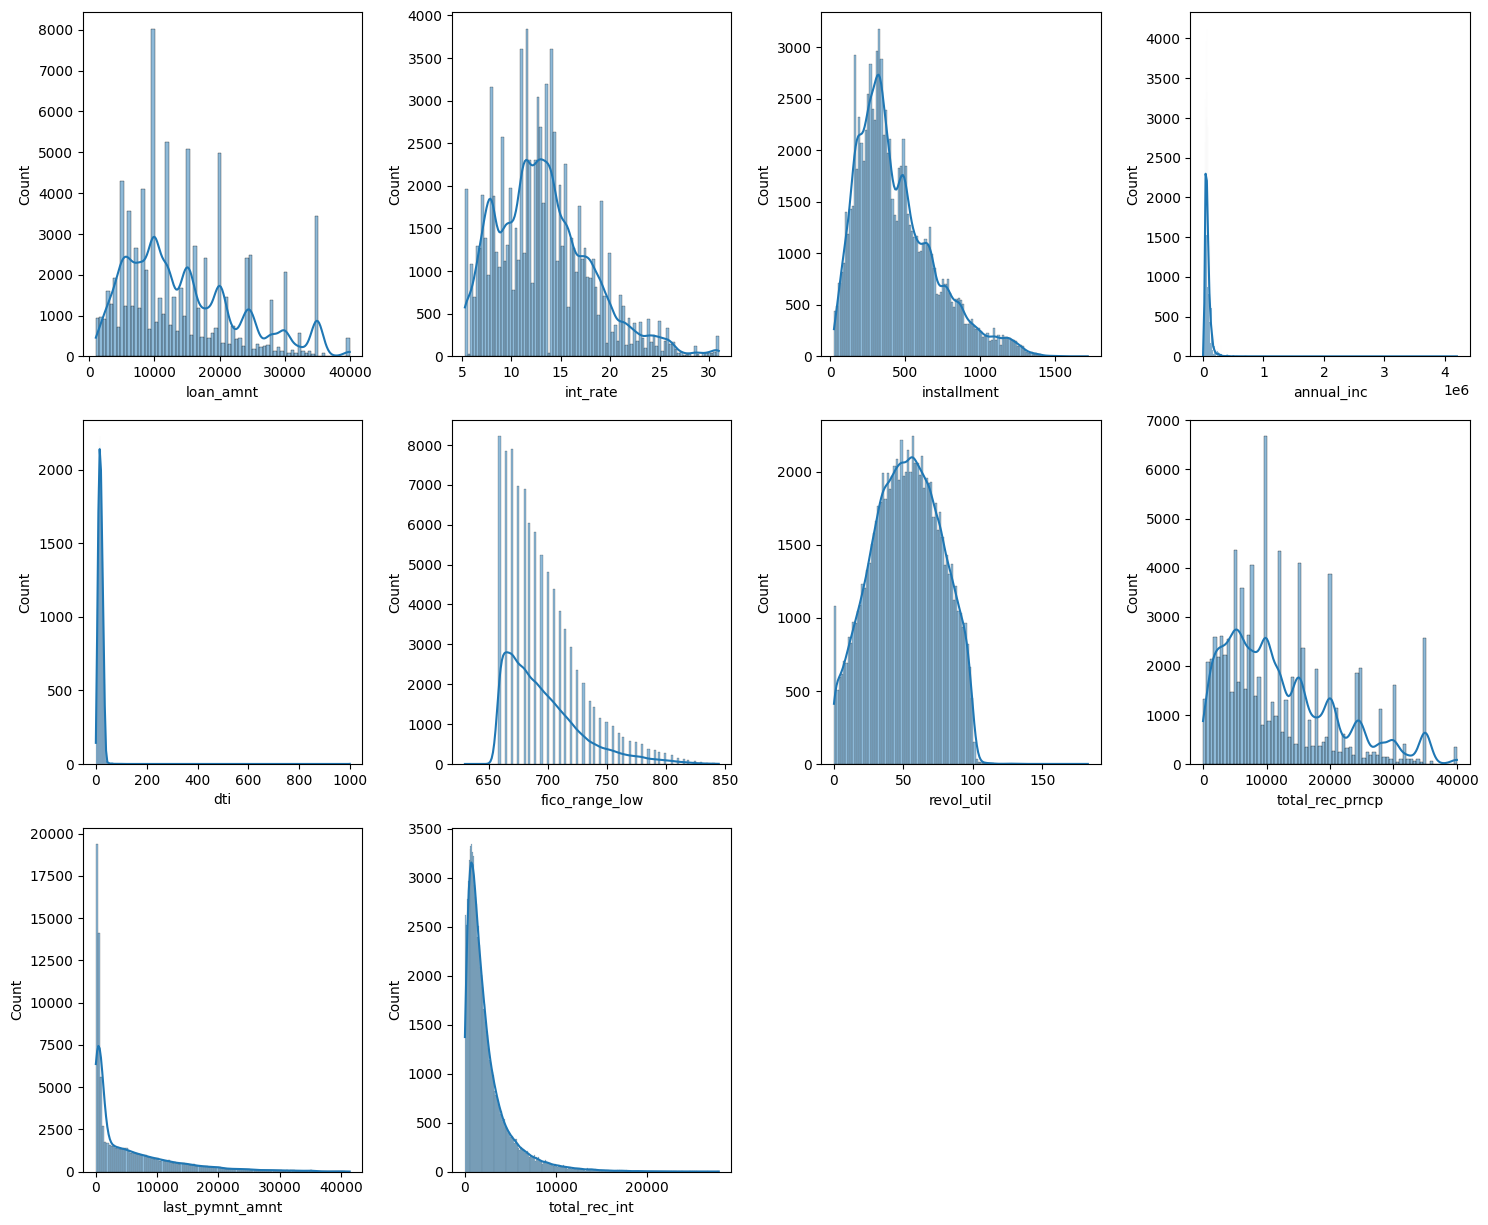

In [255]:
plt.figure(figsize=(15,16))
for i,col in enumerate(num_cols,1):
    plt.subplot(4,4,i)
    sb.histplot(df[col],kde=True)

plt.tight_layout()
plt.show();

In [34]:
def capped(df,col,upper_threshold = 0.99,lower_threshold = 0.01):
    upper_bound = df[col].quantile(upper_threshold)
    lower_bound = df[col].quantile(lower_threshold)
    
    df[col] = np.where(df[col] > upper_bound,upper_bound,
             np.where(df[col] < lower_bound,lower_bound,df[col]))
    
    return df[col]

In [35]:
cols_to_cap = ['int_rate', 'dti', 'annual_inc', 'revol_util','installment']

for col in cols_to_cap:
    df[col] = capped(df,col)

In [36]:
train,test = train_test_split(df,test_size = 0.2,random_state = 42,stratify = df['loan_status'])

In [37]:
purpose_cnt = train['purpose'].value_counts()
train['purpose'] = train['purpose'].map(purpose_cnt)
test['purpose'] = test['purpose'].map(purpose_cnt)

In [38]:
test.isnull().sum()

loan_amnt                 0
int_rate                  0
installment               0
grade                     0
emp_length             1070
annual_inc                0
dti                       0
fico_range_low            0
revol_util               10
total_rec_prncp           0
purpose                   0
loan_status               0
verification_status       0
last_pymnt_amnt           0
total_rec_int             0
dtype: int64

In [39]:
mode_imputer = SimpleImputer(strategy = 'most_frequent')
train['emp_length'] = mode_imputer.fit_transform(train[['emp_length']])
test['emp_length'] = mode_imputer.transform(test[['emp_length']])

<Axes: xlabel='revol_util', ylabel='Count'>

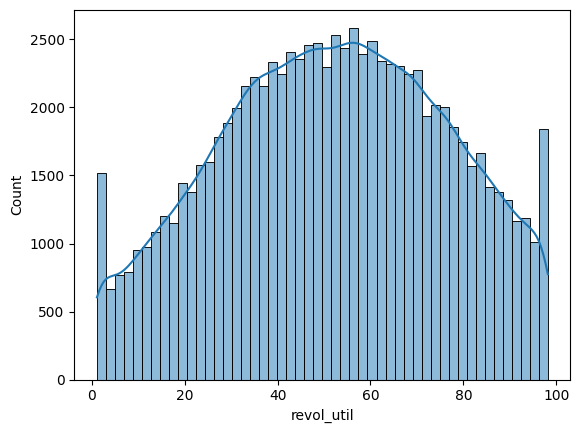

In [40]:
sb.histplot(df['revol_util'],bins = 50,kde = True)

In [41]:
median_imputer = SimpleImputer(strategy = 'median')
train['revol_util'] = median_imputer.fit_transform(train[['revol_util']])
test['revol_util'] = median_imputer.transform(test[['revol_util']])

<Axes: xlabel='annual_inc', ylabel='emp_length'>

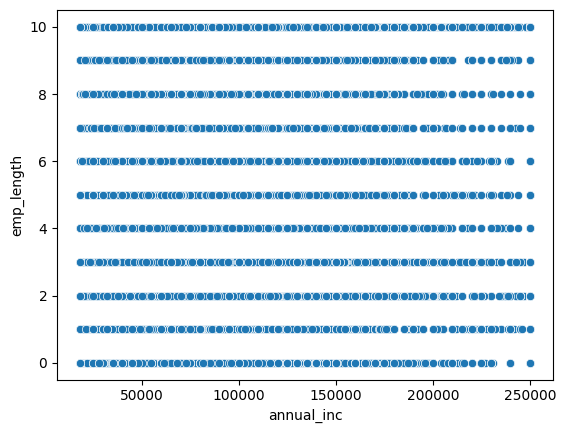

In [42]:
sb.scatterplot(x = df['annual_inc'],y = df['emp_length'])

In [43]:
num_cols = df.select_dtypes(include = ['int','float64']).columns
df[num_cols].describe()

,loan_amnt,int_rate,installment,grade,emp_length,annual_inc,dti,fico_range_low,revol_util,total_rec_prncp,loan_status,verification_status,last_pymnt_amnt,total_rec_int
count,89984.000000,89984.000000,89984.000000,89984.000000,84801.000000,89984.000000,89984.000000,89984.000000,89925.000000,89984.000000,89984.000000,89984.000000,89984.000000,89984.000000
mean,14384.823969,13.253496,436.297198,1.753790,5.961357,74587.213368,18.157584,696.097139,51.946196,12135.722749,0.199680,0.985386,5406.125905,2398.152766
std,8716.352448,4.699153,258.649386,1.298439,3.693394,42177.477351,8.432767,31.842372,24.393466,8852.786687,0.399762,0.781894,7112.540716,2606.625489
min,1000.000000,5.320000,52.033200,0.000000,0.000000,18000.000000,1.790000,630.000000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7900.000000,9.750000,247.430000,1.000000,2.000000,45100.000000,11.810000,670.000000,33.700000,5000.000000,0.000000,0.000000,400.237500,763.722500
50%,12000.000000,12.740000,373.730000,2.000000,6.000000,65000.000000,17.650000,690.000000,52.400000,10000.000000,0.000000,1.000000,2016.090000,1567.735000
75%,20000.000000,16.020000,580.290000,3.000000,10.000000,90000.000000,24.070000,710.000000,70.700000,17100.000000,0.000000,2.000000,8162.990000,3038.225000
max,40000.000000,26.490000,1218.610000,6.000000,10.000000,250340.000000,38.530000,845.000000,98.200000,40000.000000,1.000000,2.000000,41453.070000,27862.510000


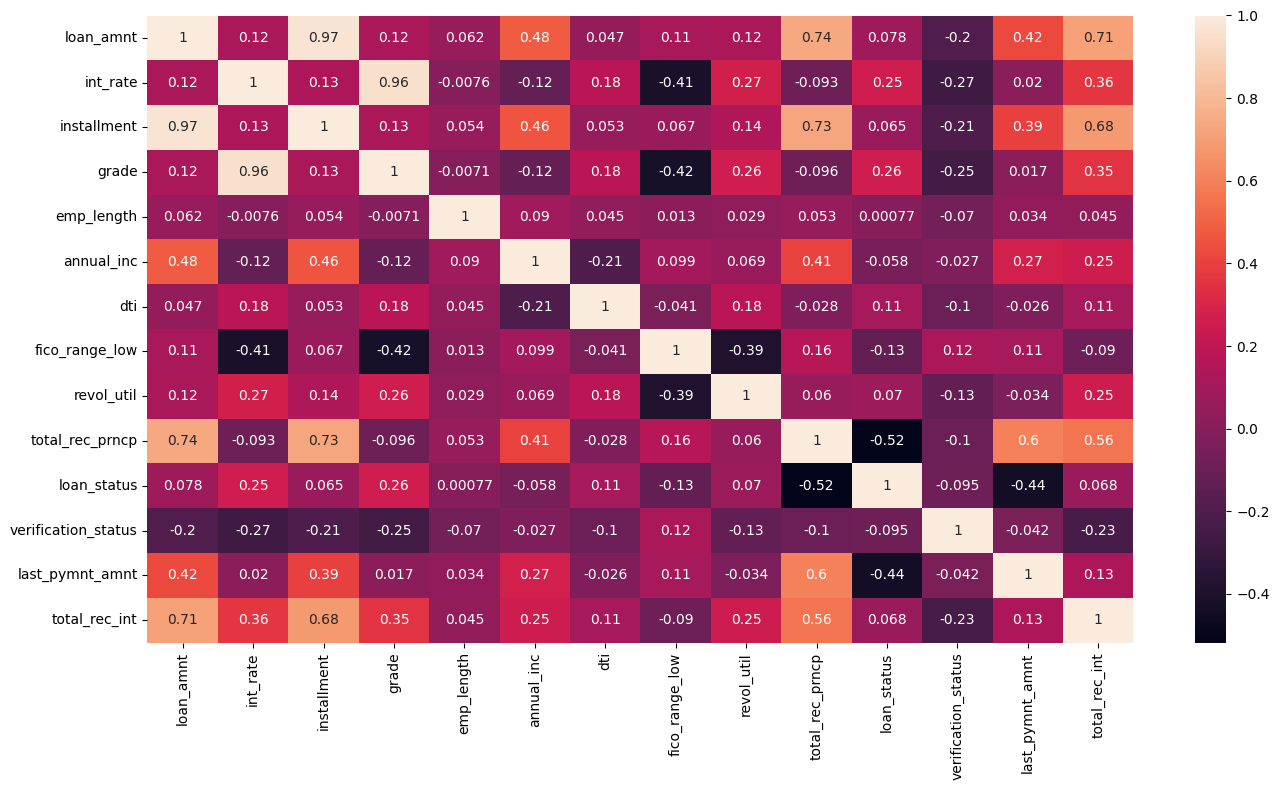

In [250]:
plt.figure(figsize=(14,8))
sb.heatmap(train.drop('purpose',axis=1).corr(method='spearman'),annot=True)
plt.tight_layout()
plt.show();

In [251]:
from sklearn.feature_selection import SelectKBest, chi2

select = SelectKBest(score_func = chi2,k = 6)
train_select = select.fit_transform(x_train,y_train)
print(f"Selected Features: {x_train.columns[select.get_support()]}")

Selected Features: Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_low',
       'verification_status'],
      dtype='object')


In [44]:
selected_features = ['loan_amnt', 'int_rate',
       'annual_inc', 'dti', 'fico_range_low', 'verification_status']

In [146]:
x_train = train[selected_features]
x_test = test[selected_features]
y_train = train['loan_status']
y_test = test['loan_status']

In [147]:
print(f"x_train_shape: {x_train.shape}, x_test_shape: {x_test.shape}")
print(f"y_train_shape: {y_train.shape}, y_test_shape: {y_test.shape}")


x_train_shape: (71987, 6), x_test_shape: (17997, 6)
y_train_shape: (71987,), y_test_shape: (17997,)


In [148]:
def model_report(model,x_test,y_test):
    y_pred = model.predict(x_test)
    print(f"Recall: {recall_score(y_test,y_pred):.2f}")
    print(f"Precision: {precision_score(y_test,y_pred):.2f}")
    cm = confusion_matrix(y_test,y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm,
                                               display_labels = [0,1])
    cm_display.plot();

In [181]:
param_grid = {
    'n_estimators' : [100,200,300,400,500,600],
    'max_depth' : [7,10,12,8,9,11,13,14,None],
    'min_samples_split' : [5,10,19,11,17,19,22,25,15,20],
    'max_features' : [None,'sqrt','log2'],
    'class_weight' : ['balanced',{0:1,1:4},{0:1,1:5},{0:1,1:3}],
    'min_samples_leaf' : [10,15,20,25,30,45]
}
rfr = RandomForestClassifier(random_state = 42)
random_rfr = RandomizedSearchCV(estimator = rfr,
            param_distributions = param_grid,
            scoring = 'recall',
            n_iter = 25,
            n_jobs = -1,
            cv = StratifiedKFold(n_splits = 5,shuffle=True,random_state = 42),
            verbose = 1,
            random_state = 42)
random_rfr.fit(x_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         {0: 1, 1: 4},
                                                         {0: 1, 1: 5},
                                                         {0: 1, 1: 3}],
                                        'max_depth': [7, 10, 12, 8, 9, 11, 13,
                                                      14, None],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': [10, 15, 20, 25, 30,
                                                             45],
                                        'min_samples_split': [5, 10, 19, 11, 17,
                                                              19, 22, 25, 15,
                                                              20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600]},
                   random_state=42, scoring='recall', verbose=1)

Recall: 0.73
Precision: 0.28


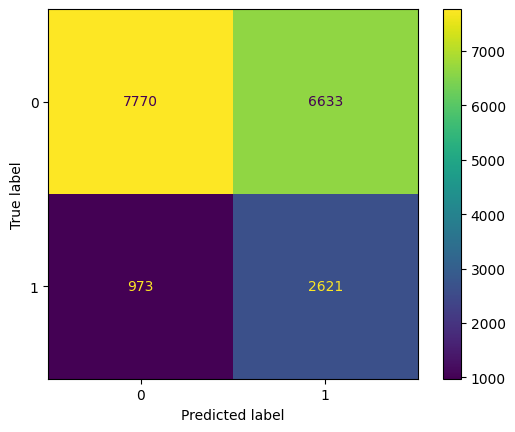

In [256]:
model_report(random_rfr.best_estimator_,x_test,y_test)

In [171]:
xgb_params = {
    'n_estimators' : [100,200,350,450,500],
    'learning_rate' : [0.01,0.1,0.2,0.05],
    'max_depth' : [6,8,9,10],
    'min_child_weight' : [7,8,9,10],
    'subsample' : [0.6,0.7,0.8,0.65,0.75],
    'colsample_bytree' : [0.6,0.75,0.7,0.8,0.65],
    'gamma' : [0.1,0.2,0.3],
    'reg_alpha' : [0,0.01,0.1,1],
    'reg_lambda' : [1,3,5,10],
    'scale_pos_weight' : [1,3,4,5,7,(len(y_train[y_train] == 0) / len(y_train[y_train] == 1))]
}

xgb_model = XGBClassifier(random_state = 42)
random_search = RandomizedSearchCV(
    estimator = xgb_model,
    param_distributions = xgb_params,
    n_iter = 18,
    cv = StratifiedKFold(n_splits = 5,shuffle = True,random_state = 42),
    n_jobs = -1,
    verbose = 1,
    scoring = 'recall',
    random_state = 42
)
random_search.fit(x_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                   param_distributions={'colsample_bytree': [0.6, 0.75, 0.7,
                                                             0.8, 0.65],
                                        'gamma': [0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.05],
                                        'max_depth': [6, 8, 9, 10],
                                        'min_child_weight': [7, 8, 9, 10],
                                        'n_estimators': [100, 200, 350, 450,
                                                         500],
                                        'reg_alpha': [0, 0.01, 0.1, 1],
                                        'reg_lambda': [1, 3, 5, 10],
                                        'scale_pos_weight': [1, 3, 4, 5, 7,
                                                             1.0],
                                        'subsample': [0.6, 0.7, 0.8, 0.65,
                                                      0.75]},
                   random_state=42, scoring='recall', verbose=1)

Recall: 0.91
Precision: 0.24


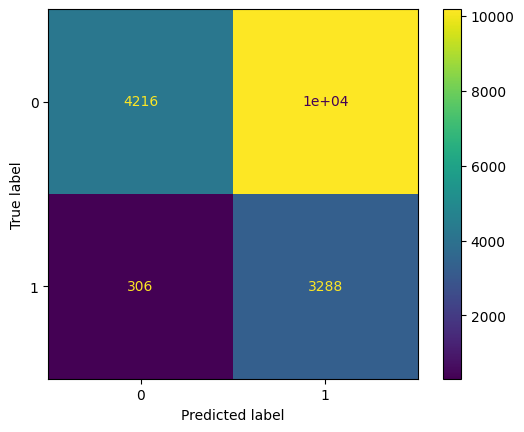

In [173]:
model_report(random_search.best_estimator_,x_test,y_test)

In [207]:
voting_clf = VotingClassifier(
    estimators = [
        ('rfr', grid.best_estimator_),
        ('xgb', random_search.best_estimator_),
        #('gbc', gbc_search.best_estimator_)
        ],
    voting = 'soft',
    n_jobs = -1
)
voting_clf.fit(x_train,y_train)

VotingClassifier(estimators=[('rfr',
                              RandomForestClassifier(class_weight={0: 1, 1: 5},
                                                     max_depth=7,
                                                     max_features=None,
                                                     min_samples_leaf=45,
                                                     min_samples_split=17,
                                                     n_estimators=600,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_roun...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None, min_child_weight=8,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 n_jobs=-1, voting='soft')

In [239]:
y_pred_proba = voting_clf.predict_proba(x_test)[:, 1]
y_pred_adjusted = (y_pred_proba > 0.5).astype(int)

print(confusion_matrix(y_test,y_pred_adjusted))

[[6111 8292]
 [ 584 3010]]


In [240]:
recall_score(y_test,y_pred_adjusted)

0.8375069560378409

In [248]:
cv = StratifiedKFold(n_splits = 5,shuffle=True,random_state = 42)

cv_scores = cross_val_score(voting_clf,
                            x_train,
                            y_train,
                            scoring='recall',
                            cv = cv,
                            n_jobs = -1
                            )
print(f"Each Fold-score: {cv_scores}")
print(f"Average Recall: {cv_scores.mean():.3f}")

Each Fold-score: [0.84347826 0.83408696 0.83547826 0.82921739 0.82393876]
Average Recall: 0.833


In [260]:
pd.DataFrame({'Features': x_train.columns,'imp': grid.best_estimator_.feature_importances_})

,Features,imp
0,loan_amnt,0.071988
1,int_rate,0.751703
2,annual_inc,0.049873
3,dti,0.075424
4,fico_range_low,0.037762
5,verification_status,0.013249
